(1517, 2653, 3)


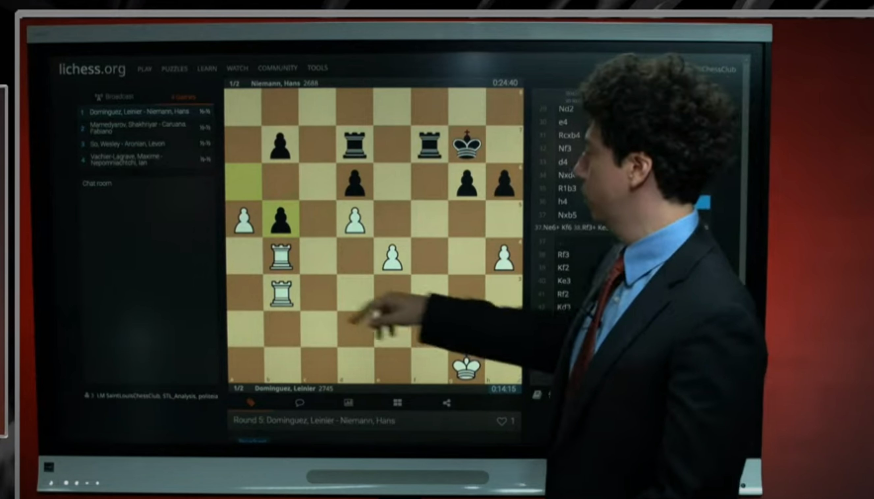

In [3]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np



img = cv2.imread('./test3.jpg')
print(img.shape)
# img = cv2.resize(img, (500, 500), interpolation=cv2.INTER_AREA)
scale_percent = 500/img.shape[0]
img = cv2.resize(img, (int(img.shape[1] * scale_percent), int(img.shape[0] * scale_percent)))
cv2_imshow(img)



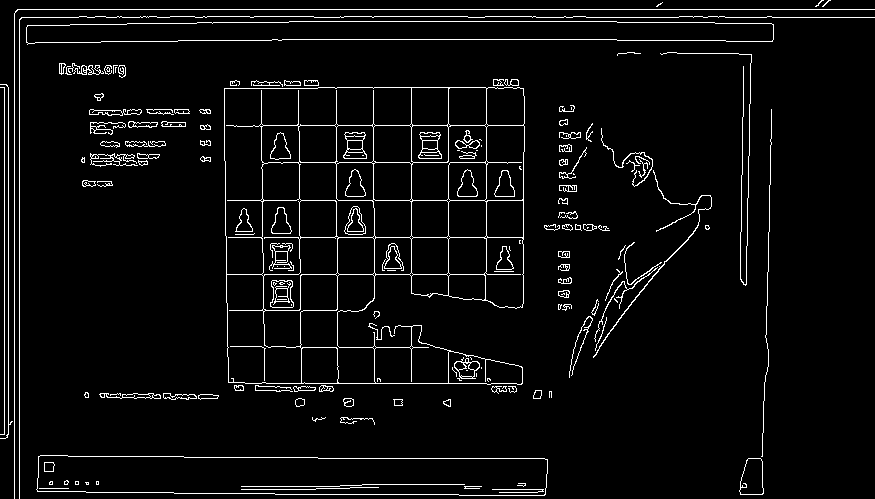

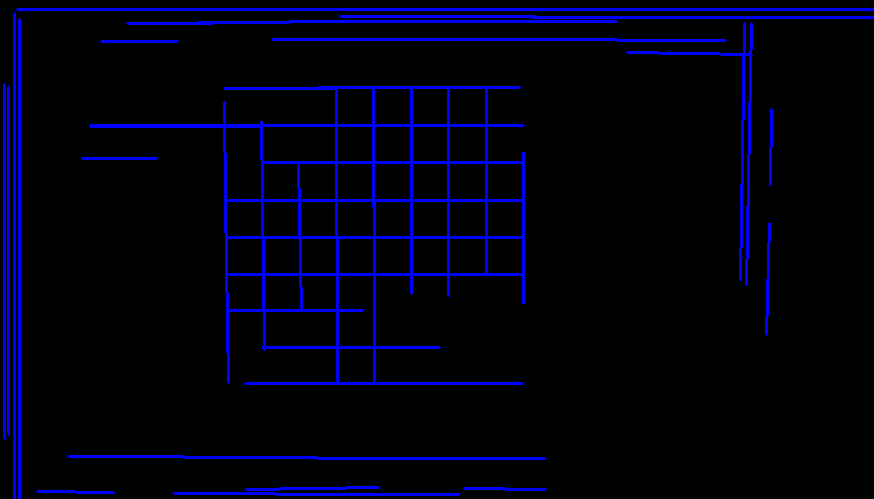

In [4]:
def edge_detect(img):
  scale_percent = 500/img.shape[0]
  img = cv2.resize(img, (int(img.shape[1] * scale_percent), int(img.shape[0] * scale_percent)))
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  low_threshold = 70
  high_threshold = 180
  edges = cv2.Canny(img_gray, low_threshold, high_threshold)
  return edges

def get_lines(img):
  rho = 1  # distance resolution in pixels of the Hough grid
  theta = np.pi / 180  # angular resolution in radians of the Hough grid
  threshold = 100  # minimum number of votes (intersections in Hough grid cell)
  min_line_length = 70  # minimum number of pixels making up a line
  max_line_gap = 25  # maximum gap in pixels between connectable line segments

  # Run Hough on edge detected image
  # Output "lines" is an array containing endpoints of detected line segments
  lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                      min_line_length, max_line_gap)
  return lines

def show_lines(img, lines):
  line_image = np.copy(img) * 0  # creating a blank to draw lines on
  for i,line in enumerate(lines):
    # print(line)
    line_id[i] = line[0]
    if len(line) > 0:
      x1, y1, x2, y2 = line[0]
      cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),2)
  cv2_imshow(line_image)
  
img_edge = edge_detect(img)
W = img_edge.shape[0]
H = img_edge.shape[1]
lines = get_lines(img_edge)
line_id = [None] * len(lines) # REFACTOR THIS
cv2_imshow(img_edge)
show_lines(img, lines)

In [5]:
len(line_id)

50

In [6]:
parent = [-1 ]* len(line_id)
size =  [-1 ]* len(line_id)
def make_set(v):
  parent[v] = v
  size[v] = 1

def find_set(v):
  if(v == parent[v]):
    return v
  parent[v] = find_set(parent[v])
  return parent[v]

def union_sets(a,b):
  a = find_set(a)
  b = find_set(b)
  if a != b:
    if(size[a] < size[b]):
      a,b = b,a 
    parent[b] = a
    size[a] += size[b]


In [7]:
from numpy.linalg import norm
import math
import time

def dist(p, p1, p2):
  # t6 = time.time()
  p1p2 = [p2[0] - p1[0], p2[1] - p1[1]]
  p1p = [p[0] - p1[0], p[1] - p1[1]]
  cross = p1p2[0] * p1p[1] - p1p2[1] * p1p[0]
  length = math.sqrt(p1p2[0]**2 + p1p2[1]**2)
  ret = abs(cross)/length
  # t7 = time.time()
  # print(t7-t6)
  return ret

def similar(l1, l2):
  l1x1, l1y1, l1x2, l1y2 = l1
  l2x1, l2y1, l2x2, l2y2 = l2

  #todo: come up with better heuristic
  # t6 = time.time()
  dx1 = dist([l2x1, l2y1], [l1x1, l1y1], [l1x2, l1y2])
  dx2 = dist([l2x2, l2y2], [l1x1, l1y1], [l1x2, l1y2])
  dy1 = dist([l1x2, l1y2], [l2x1, l2y1], [l2x2, l2y2])
  dy2 = dist([l1x1, l1y1], [l2x1, l2y1], [l2x2, l2y2])
  # t7 = time.time()
  # print(t7-t6)
  gamma = 0.25*(dx1 + dx2 + dy1 + dy2) + 0.01
  p = 2
  omega = np.pi/2 * 1/((W*H)**(1/4))
  t_delta = p*omega
  a = math.sqrt((l1y2-l1y1)**2 + (l1x2-l1x1)**2)
  b = math.sqrt((l2y2-l2y1)**2 + (l2x2-l2x1)**2)
  delta = (a + b) * t_delta
  sim = (a/gamma > delta or b/gamma > delta)
  return sim

0.09584903717041016


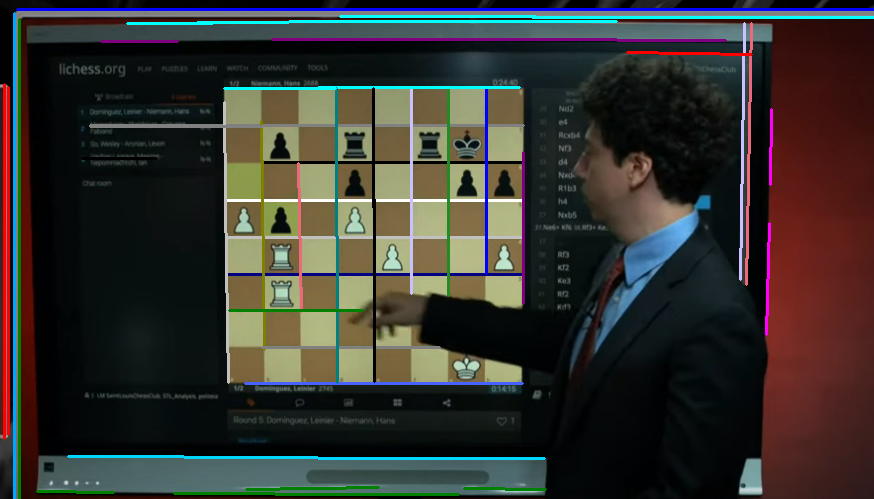

[0, 1, 2, 3, 2, 5, 6, 5, 8, 2, 10, 11, 12, 13, 14, 15, 16, 17, 2, 19, 20, 6, 22, 23, 24, 23, 26, 27, 16, 29, 30, 31, 13, 33, 31, 35, 16, 33, 29, 39, 23, 2, 6, 43, 22, 45, 23, 10, 27, 23]
defaultdict(<class 'list'>, {0: [array([ 17,   9, 874,   9], dtype=int32)], 1: [array([ 14, 498,  14,  13], dtype=int32)], 2: [array([340,  16, 535,  16], dtype=int32), array([532,  17, 874,  17], dtype=int32), array([289,  21, 616,  21], dtype=int32), array([197,  22, 288,  22], dtype=int32), array([127,  23, 212,  23], dtype=int32)], 3: [array([ 19, 498,  19,  19], dtype=int32)], 5: [array([  4, 438,   4,  84], dtype=int32), array([  8, 434,   8,  87], dtype=int32)], 6: [array([272,  39, 616,  39], dtype=int32), array([617,  40, 725,  40], dtype=int32), array([101,  41, 177,  41], dtype=int32)], 8: [array([226, 274, 522, 274], dtype=int32)], 10: [array([ 90, 125, 523, 125], dtype=int32), array([ 90, 126, 262, 126], dtype=int32)], 11: [array([226, 237, 523, 237], dtype=int32)], 12: [array([225, 200, 5

In [8]:
from collections import defaultdict
st= time.time()

for id in range(len(line_id)):
  make_set(id)

t2 = time.time()
for id1 in range(len(line_id)):
  for id2 in range(id1, len(line_id)):
    if similar(line_id[id1], line_id[id2]):  
      union_sets(id1, id2)
t3 = time.time()
print(t3-t2)

colors = [
    (255, 0, 0),    # Red
    (255, 165, 0),  # Orange
    (255, 255, 0),  # Yellow
    (0, 128, 0),    # Green
    (0, 128, 128),  # Teal
    (0, 0, 255),    # Blue
    (128, 0, 128),  # Purple
    (255, 0, 255),  # Magenta
    (128, 0, 0),    # Maroon
    (128, 128, 0),  # Olive
    (128, 128, 128),# Grey
    (192, 192, 192),# Silver
    (255, 255, 255),# White
    (0, 0, 0),      # Black
    (255, 99, 71),  # Tomato
    (255, 192, 203),# Pink
    (255, 215, 0),  # Gold
    (34, 139, 34),  # Forest green
    (70, 130, 180), # Steel blue
    (123, 104, 238) # Medium purple
]

line_image2 = np.copy(img)

groups = defaultdict(list)
for id in range(len(line_id)):
  group_id = find_set(id)
  c = colors[group_id%len(colors)]
  line = line_id[id]
  groups[group_id].append(line)
  x1, y1, x2, y2 = line
  cv2.line(line_image2,(x1,y1),(x2,y2),c,2)

cv2_imshow(line_image2)

print(parent)
print(groups)

In [9]:
t4 = time.time()
print(similar([0,0,1,1], [2.2,2.3,3,3]))
t5 = time.time()
print(t5-t4)

True
0.0012748241424560547


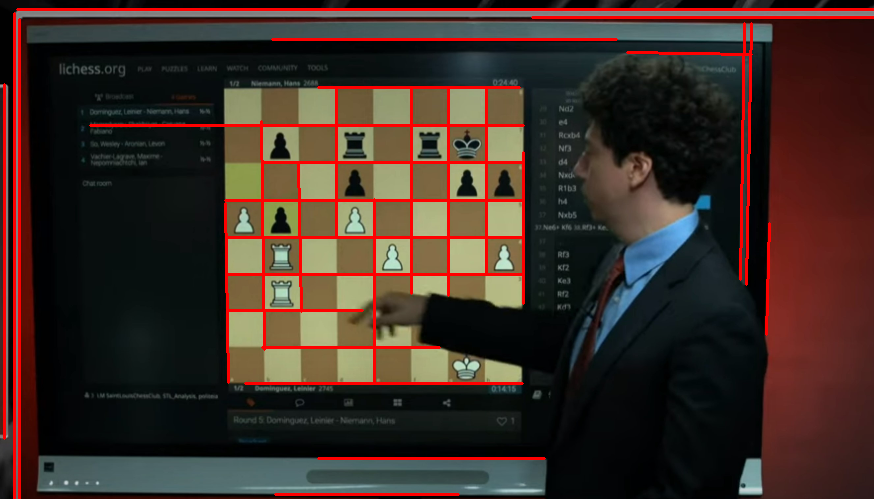

In [10]:
line_image3 = np.copy(img)
merged_lines = []
for group_id in groups:
  group = groups[group_id]
  max_len = 0
  max_idx = 0
  for i,line in enumerate(group):
    length = (line[3]-line[1])**2 + (line[2]-line[0])**2
    if length > max_len:
      max_len = length
      max_idx = i
  line = group[max_idx]
  merged_lines.append(line)
  cv2.line(line_image3,(line[0],line[1]),(line[2],line[3]),(0,0,255),2)
  
cv2_imshow(line_image3)

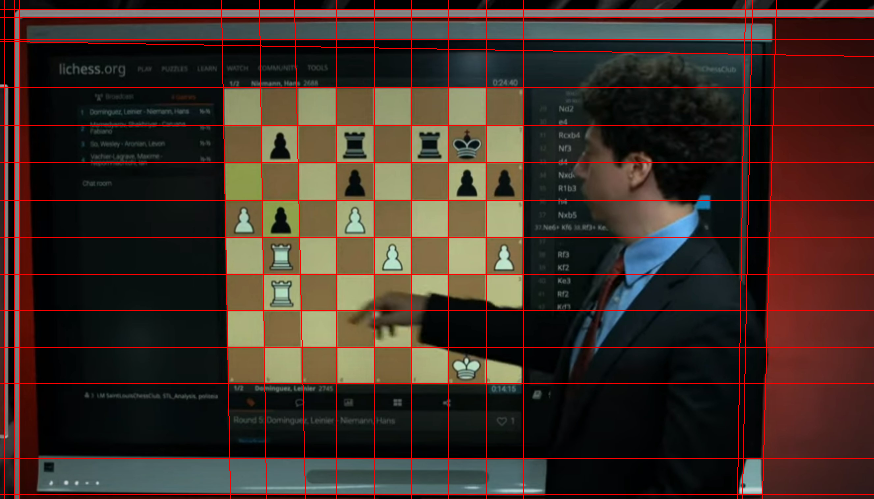

In [11]:
from pickle import TUPLE1
class Line():
  def __init__(self, point, vector):
    self.point = point
    self.vector = vector

full_lines = []
def magnitude(v):
  return math.sqrt(v[0]**2 + v[1]**2)

def find_intersection(l1, l2):
  x1,y1 = l1.point
  u1,v1 = l1.vector
  x2,y2 = l2.point
  u2,v2 = l2.vector
  det = -u1*v2 + v1*u2
  if abs(det) < 0.0000001: 
    return 1000000000, [1000000000, 1000000000]
  t = (-v2*(x2-x1) + u2*(y2-y1))/det
  return [x1 + t*u1, y1 + t*v1]

for line in merged_lines:
  d = [line[2] - line[0], line[3] - line[1]]
  full_lines.append(Line([line[0], line[1]], d))

line_image4 = np.copy(img)

for line in full_lines:
  cv2.line(line_image4,(int(line.point[0]+500*line.vector[0]), int(line.point[1]+500*line.vector[1])),(int(line.point[0] - 500*line.vector[0]), int(line.point[1] - 500*line.vector[1])),(0,0,255),1)
cv2_imshow(line_image4)


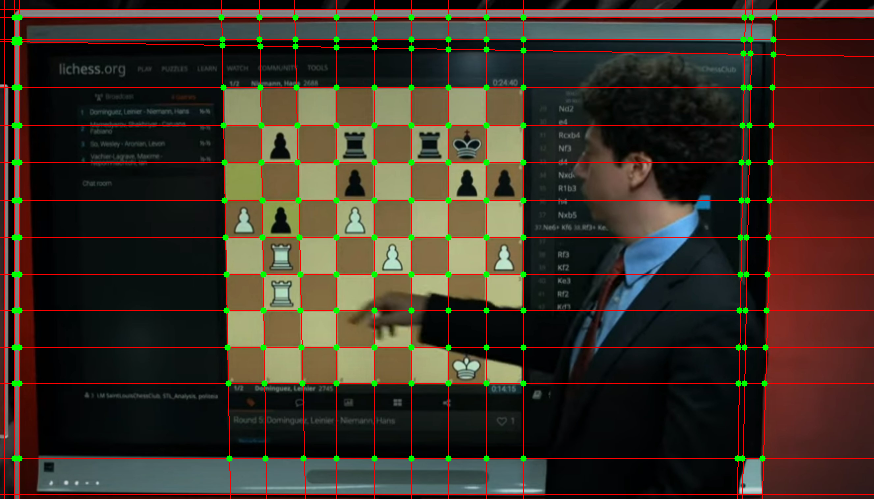

In [12]:
inter_images = []

for i in range(len(full_lines)):
  for j in range(i+1, len(full_lines)):
    point_inter = find_intersection(full_lines[i], full_lines[j])
    if(point_inter[0] >= 11 and point_inter[0] < H-11 and point_inter[1] >= 11 and point_inter[1] < W-11):
      cv2.circle(line_image4, (int(point_inter[0]), int(point_inter[1])), 3, (0, 255, 0), -1)
      roi = img[int(point_inter[1])-10: int(point_inter[1])+11, int(point_inter[0])-10: int(point_inter[0])+11]
      if(len(roi) == 0):
        print("empty")
        print(point_inter[0], point_inter[1])
      inter_images.append(roi)
cv2_imshow(line_image4)

In [13]:
for im in inter_images:
  gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  th = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,21,2)
  cv2_imshow(th)
  ret, corners = cv2.findChessboardCorners(th, (3,3), None)
  cv2.drawChessboardCorners(th, (3,3), corners,ret)
  print()


# Intersection Classification

In [16]:
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/ok/2517754059478547988.jpg  
  inflating: data/ok/-8896413441695728204.jpg  
  inflating: data/ok/-4038019199864736990_90.jpg  
  inflating: data/ok/3395102819547706846_180.jpg  
  inflating: data/ok/6435535882199308555_270.jpg  
  inflating: data/ok/1857397537820341460_180.jpg  
  inflating: data/ok/7088880965531492320.jpg  
  inflating: data/ok/3972380226290087302_180.jpg  
  inflating: data/ok/7913608948582337967_90.jpg  
  inflating: data/ok/-394917516562167653_270.jpg  
  inflating: data/ok/-7968535116429408034_180.jpg  
  inflating: data/ok/-3170505566557376314_180.jpg  
  inflating: data/ok/-3740495164911687941.jpg  
  inflating: data/ok/-2934383283674695245.jpg  
  inflating: data/ok/1565963575110519410_180.jpg  
  inflating: data/ok/-6196041164866944428_90.jpg  
  inflating: data/ok/5732773055361840100_90.jpg  
  inflating: data/ok/-6098190147036247365_270.jpg  
  inflating: data/ok/-8890661928743610539_180.j

In [51]:
import torch
from torchvision import datasets, transforms

data = datasets.ImageFolder('data', transform=transforms.ToTensor())

In [52]:
train_set, val_set = torch.utils.data.random_split(data, [0.1, 0.9])
train_data = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_data = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True)

In [53]:
train_data

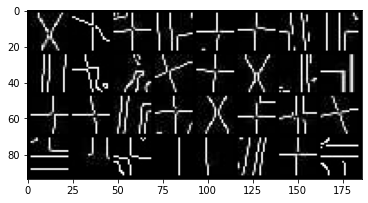

1 1 1 0 1 1 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 1 0 1 0 0 1 0 0 0 1 0


In [56]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_data)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{labels[j]}' for j in range(32)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,6,5)
    